In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from scipy.signal import savgol_filter
%matplotlib inline

In [12]:
metadata = pd.read_csv('metadata.csv')
train_labels = pd.read_csv('train_labels.csv')
all_ids = list(metadata.sample_id)
metadata.head()

,sample_id,split,derivatized,features_path,features_md5_hash
0,S0000,train,NaN,train_features/S0000.csv,52ec6d6f8372500ab4e069b5fbdae6f9
1,S0001,train,NaN,train_features/S0001.csv,348f90baed8a8189bf0d4c7b9ed9f965
2,S0002,train,1.0,train_features/S0002.csv,4686ad9bc3716966f63b6ff83d1d8324
3,S0003,train,NaN,train_features/S0003.csv,de6b53605c5887967dc3661a3a711c2b
4,S0004,train,NaN,train_features/S0004.csv,fbfd90092d10d15a5d6919327ddde2ab


In [129]:

def metadata_parser(metadata):
    train_dict = {}
    val_dict = {}
    for row in metadata.iterrows():
        if row[1].split == 'train':
            train_dict[row[1].sample_id] = row[1].features_path
        else:
            val_dict[row[1].sample_id] = row[1].features_path
    return train_dict, val_dict

def train_label_parser(train_labels):
    train_labels_dict = {}
    for row in train_labels.iterrows():
        row_list = list(row[1])
        train_labels_dict[row_list[0]] = row_list[1:]
    columns = list(train_labels.columns)
    return train_labels_dict, columns[1:]

def get_ids_per_class():
    ids_per_class = {}
    for class_name in labels:
        index = labels.index(class_name)
        ids = []
        for key, value in train_labels_dict.items():
            if value[index] == 1:
                ids.append(key)
        ids_per_class[class_name] = ids
    return ids_per_class

def find_absolute_maximum_mass():
    print("Finding absolute maximum mass")
    pb = tqdm(total=len(all_ids))
    absolute_max = 0
    for key, value in all_paths.items():
        pb.update(1)
        data = pd.read_csv(value)
        data.sort_values('mass')
        max_mass = data['mass'].max()
        absolute_max = max(absolute_max, max_mass)
    return absolute_max

def data_parser(id):
    path = all_paths[id]
    data = pd.read_csv(path)
    data = data.sort_values('mass')
    labels = list(data.columns)
    data_json = {
        'time': np.array(data.time),
        'mass': np.array(data.mass),
        'intensity': np.array(data.intensity),
    }
    return data_json

def descretize(data, mass_range, interval):
    mass = data['mass'].copy()
    intensity = data['intensity'].copy()
    num_elements = int(mass_range / interval) + 1
    intensity_desc = np.zeros(num_elements)
    for i in range(num_elements):
        mass_start = i * interval
        mass_end = (i + 1) * interval
        mask = (mass >= mass_start) & (mass < mass_end)
        if np.any(mask):
            intensity_desc[i] = np.max(intensity[mask])
    return intensity_desc

def intensity_vs_mass_plotter(sample_id, discretized=False, mass_range=650, interval=0.5):
    data = data_parser(sample_id)
    if discretized:
        data['intensity'] = descretize(data, mass_range, interval)
        data['mass'] = np.array([i*interval for i in range(len(data['intensity']))])
    fig, axs = plt.subplots(figsize=(20, 10))
    axs.set_xlim(0, 650)
    axs.plot(data['mass'], data['intensity'])

def abosulte_average_deviation():
    deviations = 0
    count = 0
    for sample_id in tqdm(all_ids):
        data = data_parser(sample_id)
        mass = data['mass']
        for i in range(len(mass) - 1):
            deviations += np.abs(mass[i+1] - mass[i])
            count += 1
    return deviations, count

    

train_path, val_path = metadata_parser(metadata)
train_labels_dict, labels = train_label_parser(train_labels)
all_paths = {**train_path, **val_path}
ids_per_class = get_ids_per_class()
# absolute_maximum_mass = find_absolute_maximum_mass()   Already found
# absolute_average_deviation, total_count = abosulte_average_deviation()
absolute_maximum_mass = 649.96228 
absolute_mean_diff = 544345.6024272853/591544015
print("ALl labels:", labels)
print("Maximum mass:", absolute_maximum_mass)

ALl labels: ['aromatic', 'hydrocarbon', 'carboxylic_acid', 'nitrogen_bearing_compound', 'chlorine_bearing_compound', 'sulfur_bearing_compound', 'alcohol', 'other_oxygen_bearing_compound', 'mineral']
Maximum mass: 649.96228


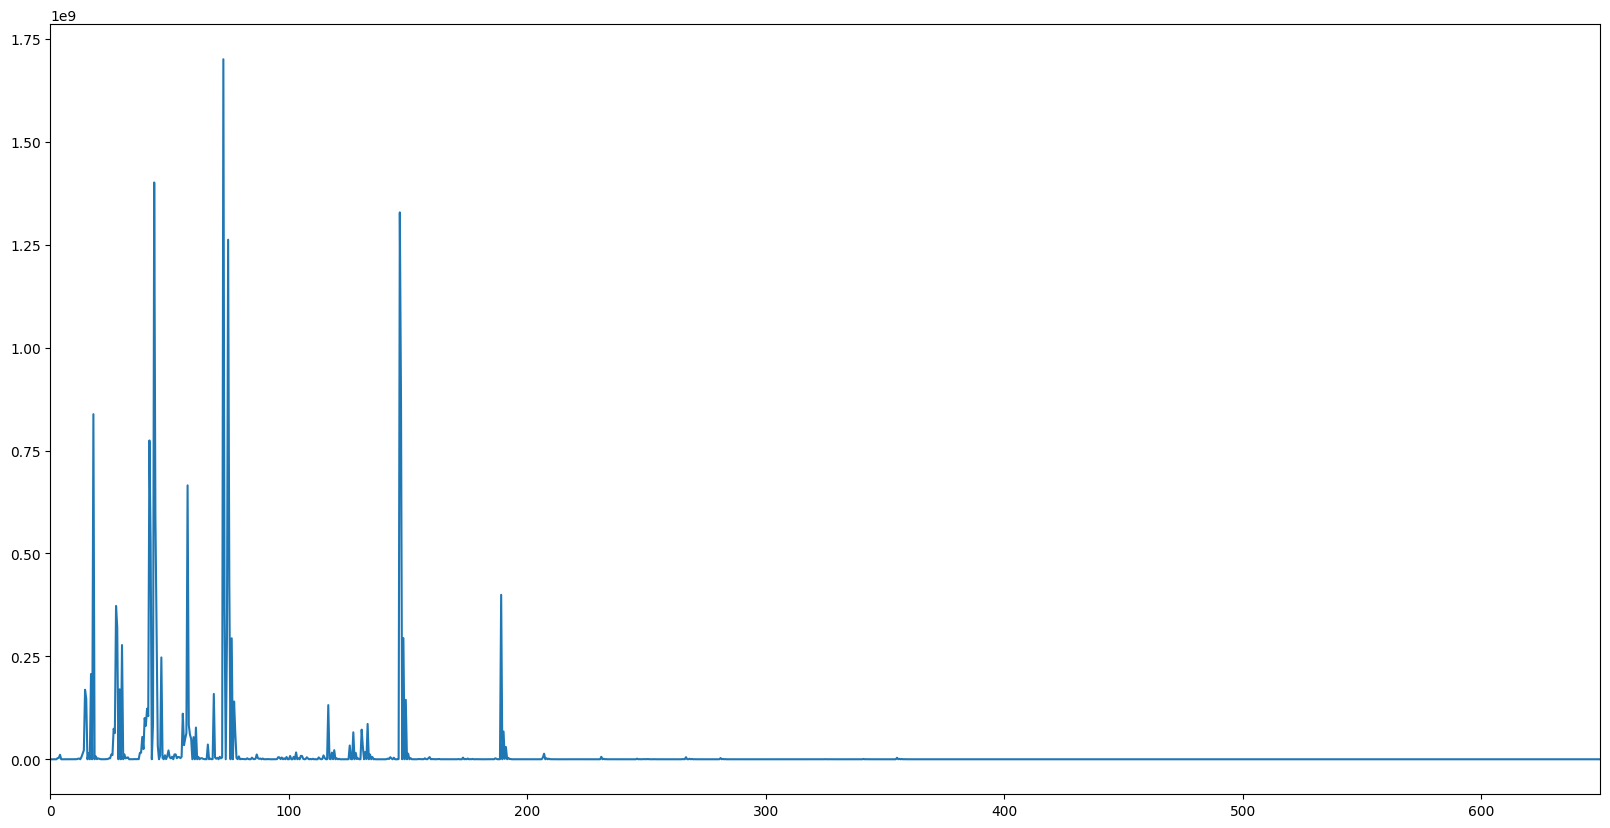

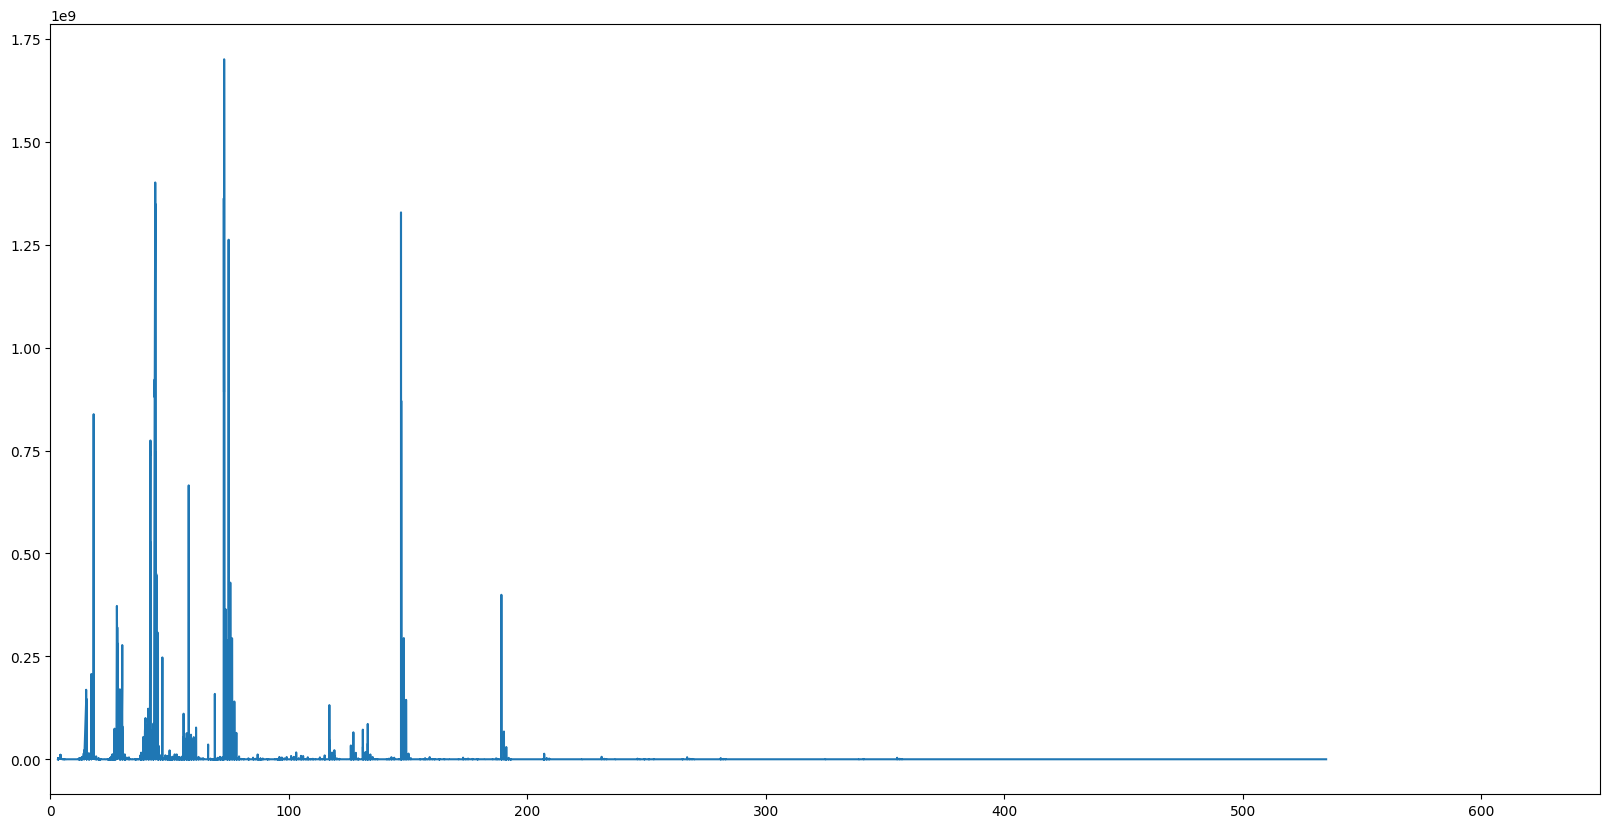

In [130]:
intensity_vs_mass_plotter('S0000', True)
intensity_vs_mass_plotter('S0000', False)